# Assignment #2

Abhilash Vikram Gupta, Hao Lun Chu Colin, Matthew Viteri, Stephen Oluwaniyi and Yeggi Lee

In [46]:
import numpy as np
import pandas as pd
import tweepy
import GetOldTweets3 as got
import re
import textblob
import nltk
import matplotlib.pyplot as plt

from sklearn import manifold
from configparser import ConfigParser
from IPython.display import display
from collections import Counter
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/matt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### A. Collect 5k tweets on the 2020 Presidential election. It is necessary to use general hashtags and search keywords (like 2020 U.S. election or 2020 Presidential Election) rather than “Trump” or “Biden” or “Warren”. Use Tweepy in your Python script, and also ask for the location specified by the user during registration with Twitter. 

In [5]:
def get_creds():
    config = ConfigParser()
    config.read('./credentials.ini')

    consumer_section = config['consumer']
    api_key, api_secret_key = consumer_section['api-key'], consumer_section['api-secret-key']

    access_section = config['access']
    access_token, access_token_secret = access_section['access-token'], access_section['access-token-secret']
    
    return api_key, api_secret_key, access_token, access_token_secret

try:
    consumer_key, consumer_secret, access_token, access_token_secret = get_creds()
except KeyError as e:
    raise IOError('Twitter credentials used are not included as part of the submitted assignment.' +
                 ' We have a csv with the collected data.') from e

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

OSError: Twitter credentials used are not included as part of the submitted assignment. We have a csv with the collected data.

In [122]:
display('Preparing...')
df = pd.DataFrame(columns=['Date', 'Username', 'User Location', 'Tweet'])

query = 'president election 2020'
start = '2019-01-01'
end = '2019-09-01'
count = 5000
tweetCriteria = (got.manager.TweetCriteria()
                 .setQuerySearch(query)
                 .setSince(start)
                 .setUntil(end)
                 .setMaxTweets(count))

display('Collecting tweets...')
tweets = got.manager.TweetManager.getTweets(tweetCriteria)

display('Creating dataframe...')
for tweet in tweets:
    df = df.append({
        'Date': tweet.date,
        'Username': tweet.username,
        'Tweet': tweet.text
    }, ignore_index=True)

display('Collecting user locations...')
for index, row in df.iterrows():
    if pd.isna(row['User Location']):
        df.at[index, 'User Location'] = api.get_user(row['Username']).location

display('Done.')
display(df)
df.to_csv(f'./{query}_({count})_{end}.csv', index=False)

'Preparing...'

'Collecting tweets...'

'Done.'

,Date,Username,User Location,Tweet
0,2019-08-29 23:59:24+00:00,BRob12071254,NaN,Cant for 2020 when we kick yalls asses out of ...
1,2019-08-29 23:57:37+00:00,JimmyJohnson911,NaN,How #Google plans to steal the 2020 election a...
2,2019-08-29 23:45:21+00:00,jpharley3000,NaN,How Google plans to steal the 2020 election aw...
3,2019-08-29 23:43:49+00:00,pmfoye,NaN,Don’t invest to much time or thought into thes...
4,2019-08-29 23:43:04+00:00,electionnewsbay,NaN,US – China Trade War Is Likely To Continue Thr...
...,...,...,...,...
4995,2019-08-09 19:27:27+00:00,TravisGleno,NaN,"If President Trump Did all of that, and screwe..."
4996,2019-08-09 19:24:42+00:00,hahahawoah,NaN,"So please write in ""Chorkle"" for President in ..."
4997,2019-08-09 19:24:25+00:00,gloriaedi,NaN,This is more of Why Trump must be Impeached an...
4998,2019-08-09 19:19:24+00:00,Claydohmusic,NaN,Ive just been given the authorization to annou...


### B.   Find FOUR key issues mentioned by the public in the tweets – e.g., character, personality, healthcare, crime, jobs, etc. (these are examples only, use wordfrequency analysis to find out). Replace words if necessary. Issues associated with Mr. Trump may not have a strong association with the democratic candidate and vice versa. So find a couple of issues that are likely to have strong association with Mr. Trump, and a couple for the democratic candidate.

In [21]:
df = pd.read_csv('president election 2020_(5000)_2019-09-01.csv', index_col=0)

In [22]:
df.head(10)

,Date,Username,User Location,Tweet
0,2019-08-31 23:46:49+00:00,MrsJaxon2004,"Maryland, USA","I’ll ask you again, can a sitting president be..."
1,2019-08-31 23:45:26+00:00,worth_two,The World,Ted Cruz is feeling uneasy about 2020 election...
2,2019-08-31 23:24:55+00:00,El_Daverino,"Texas, USA",TX Governor is not up for election until 2022....
3,2019-08-31 23:04:34+00:00,444Cin444,Looking at your star,And that is the number one reason @POTUS won’t...
4,2019-08-31 23:02:01+00:00,clevelanddotcom,"Cleveland, Ohio",Any of the top five Democratic candidates runn...
5,2019-08-31 22:49:37+00:00,nanychief,"Michigan, USA",THIS IS COMPLETE BS! WAITING UNTIL 2020 ELECTI...
6,2019-08-31 22:48:20+00:00,Aidan34655890,"East Northport, NY","I think you a great president, good luck with ..."
7,2019-08-31 22:34:04+00:00,DanielFRoche,"Cleveland, OH",Remember that it’s the President and his Cabin...
8,2019-08-31 22:32:07+00:00,ClaudiaRuff6,Follow me on Fb and Gab.ai,2020 Road To the White House the re election o...
9,2019-08-31 22:11:23+00:00,CYCYONE,"Rhode Island, USA",China called they said “We’ll wait until after...


In [23]:
same_map = {
    'trump':      ['donald', '@realdonaldtrump', 'maga', '#maga', 'trump’s', "trump's", '#trump',
                   'maga2020', '#maga2020', '#kag2020', '#kag', 'kag', 'kag2020', '#trump2020',''],
    'warren':     ['elizabeth', '@ewarren', 'elizabethwarren', '@senwarren', '#elizabethwarren'],
    'biden':      ['joe', '@joebiden', "biden's"],
    'russia':     ['russian', 'putin'],
    'republican': ['gop'],
    'musk':       ['elon']
}

same_inv_map = {word: root for root, words in same_map.items() for word in words}

def splitter(data):
    words = re.sub("([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", data.lower()).split()
    return [textblob.Word(word).lemmatize() for word in words]

def convert_same(text):
    return [(same_inv_map[word] if word in same_inv_map else word) for word in splitter(text)]

def wordCount(data):
    filtered = [w for w in convert_same(' '.join(data['Tweet'])) if w not in stop_words]
    return Counter(filtered).most_common(400)

df['Split Tweet'] = df['Tweet'].map(convert_same)

wordCount(df)

[('president', 5221),
 ('election', 5125),
 ('2020', 5050),
 ('trump', 4461),
 ('win', 655),
 ('ha', 649),
 ('u', 586),
 ('vote', 571),
 ('democrat', 515),
 ('get', 462),
 ('presidential', 461),
 ('going', 412),
 ('would', 403),
 ('people', 377),
 ('american', 375),
 ('former', 374),
 ('america', 366),
 ('republican', 363),
 ('state', 359),
 ('voter', 338),
 ('say', 330),
 ('new', 326),
 ('like', 314),
 ('wa', 303),
 ('need', 299),
 ('want', 296),
 ('one', 289),
 ('biden', 286),
 ('2016', 285),
 ('year', 272),
 ('know', 271),
 ('day', 271),
 ('time', 270),
 ('democratic', 258),
 ('russia', 256),
 ('make', 255),
 ('mr', 251),
 ('next', 249),
 ('think', 226),
 ('country', 224),
 ('fed', 224),
 ('candidate', 202),
 ('economy', 193),
 ('via', 192),
 ('lose', 187),
 ('recession', 187),
 ('great', 185),
 ('way', 182),
 ('poll', 178),
 ('keep', 177),
 ('see', 176),
 ('run', 174),
 ('support', 174),
 ('party', 174),
 ('go', 173),
 ('ahead', 170),
 ('running', 169),
 ('good', 169),
 ('united', 

#### 4 KEY ISSUES
- economy/recession 193/187
- Russia 256
- war 91
- pro-life 92
- fake 104
- racist 84
- fraud 70
- strong 75
- hate 76
- impeachment 63

#### Same words
- donald, trump, @realdonaldtrump, maga, kag <-- make america great gain
- joe, biden, @joebiden, biden's
- elizabeth, warren, @ewarren, elizabethwarren, #elizabethwarren, @senwarren
- michael, steele
- russia, russian, putin
- president, presidents
- republicans, republican, gop
- bernie, sanders

#### NOTES
- mike, pence --> running mate of Trump 
- kag --> keep america great



In [24]:
key_issues = ["economy","recession","russia","war","fake"]
key_issues_df = pd.DataFrame(columns = key_issues)
print(key_issues_df)

Empty DataFrame
Columns: [economy, recession, russia, war, fake]
Index: []


In [25]:
#Find issues that were mentioned in each post. If an issue exists in a post return 1, else return 0
def issue_mentioned(item):
    if issue in item:
        return 1
    else:
        return 0
      
for issue in key_issues:
    key_issues_df[issue] = df['Split Tweet'].apply(issue_mentioned)

In [26]:
key_issues_df[key_issues_df['war'] == 1] 

,economy,recession,russia,war,fake
5,0,0,0,1,0
77,0,0,0,1,0
176,0,0,0,1,0
234,0,0,0,1,0
253,0,0,0,1,0
255,0,0,0,1,0
328,0,0,0,1,0
348,0,0,0,1,0
439,0,0,0,1,0
446,0,0,0,1,0


In [27]:
candidates = ["trump","warren","biden"]

In [28]:

new_df = pd.DataFrame(columns = candidates)

def candidate_mentioned(item):
    if candidate in item:
        return 1.0
    else:
        return 0.0
      
for candidate in candidates:
    new_df[candidate] = df['Split Tweet'].apply(candidate_mentioned)

new_df

,trump,warren,biden
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,0.0,0.0,0.0
7,0.0,0.0,0.0
8,1.0,0.0,0.0
9,0.0,0.0,0.0


In [29]:
from itertools import combinations, product
# Calculation of lift scores
def do_lift(x, y=None):
    l1, l2 = sorted(x), sorted(y or [])
    bools = pd.DataFrame()
    for e in l1 + l2:
        bools[e] = df['Split Tweet'].map(lambda words: e in words)

    def do(df, a, b):
        count_a_int_b = np.logical_and(df[a], df[b]).values.sum()
        count_a_mult_count_b = df[a].values.sum() * df[b].values.sum()
        return len(df.index) * count_a_int_b / count_a_mult_count_b

    result_df = pd.DataFrame(index=l1, columns=(l2 or l1))
    for a, b in (combinations(l1, 2) if y==None else product(l1, l2)):
        val = do(bools, a, b)
        result_df.at[a, b] = val
        if y==None:
            result_df.at[b, a] = val

    return result_df

In [30]:

# Lift between candidates and issues
candidate_issues =pd.DataFrame(columns = key_issues)
for i in range(len(candidates)):
    for j in range(len(key_issues)):
        numerator = ((new_df[candidates[i]] + key_issues_df[key_issues[j]]) > 1.0).sum()
        denominator = new_df[candidates[i]].sum()* key_issues_df[key_issues[j]].sum()
        print(denominator)
        lift_candidate_issues = numerator*len(key_issues_df)/denominator
        candidate_issues.loc[candidates[i],key_issues[j]] = lift_candidate_issues

508690.0
490630.0
565880.0
249830.0
282940.0
10140.0
9780.0
11280.0
4980.0
5640.0
30251.0
29177.0
33652.0
14857.0
16826.0


In [31]:
candidate_issues

,economy,recession,russia,war,fake
trump,1.07138,1.3554,0.936594,0.960653,0.918923
warren,0.493097,0,0,0,0.886525
biden,0,0.342736,1.18864,0,0.297159


In [33]:
lift_matrix = do_lift(candidates,key_issues)
lift_matrix

,economy,fake,recession,russia,war
biden,0,0.297159,0.342736,1.18864,0
trump,1.07138,0.918923,1.3554,0.936594,0.960653
warren,0.493097,0.886525,0,0,0


In [113]:
lift_2 = lift_matrix[0:2]

lift_2.index

issues = {}

for c in lift_2.columns:
    for i in lift_2.index:
        col = '{}-{}'.format(c, i)
        issues[col] = lift_2[c][i]

new_df = pd.DataFrame(issues, index=[0])

new_df = new_df.transpose()
# new_df.dropna(0, inplace=True)
# new_df.head()
new_df = new_df[new_df[0] != 0]
new_df

,0
economy-trump,1.071379
fake-biden,0.297159
fake-trump,0.918923
recession-biden,0.342736
recession-trump,1.355400
russia-biden,1.188637
russia-trump,0.936594
war-trump,0.960653


In [116]:
# MDS Plot
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="euclidean", n_jobs=1)
results = mds.fit(new_df)
coords = results.embedding_

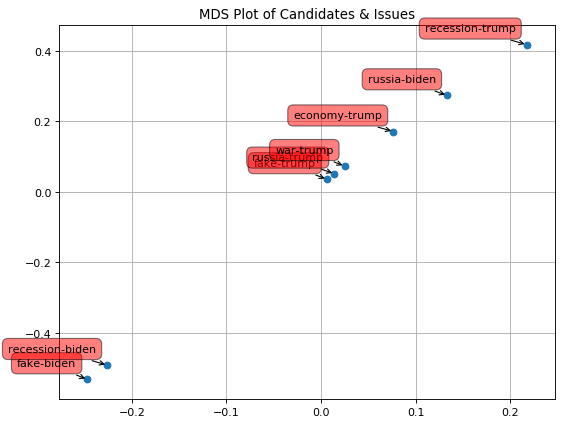

In [117]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(bottom = 0.1)
plt.scatter(coords[:, 0], coords[:, 1], marker = 'o')

for label, x, y in zip(new_df.index, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
        
plt.title('MDS Plot of Candidates & Issues')
plt.grid()
plt.show()